## 1. Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor


## 2. Loading the data

In [4]:
from torchvision import datasets, transforms

# Load FashionMNIST data
transform = transforms.Compose([ToTensor()])
train_data = FashionMNIST(root="data", train=True, download=True, transform=transform)
test_data = FashionMNIST(root="data", train=False, download=True, transform=transform)

X_train = np.array([img.numpy().squeeze() for img, _ in train_data])
y_train = np.array([label for _, label in train_data])
X_test = np.array([img.numpy().squeeze() for img, _ in test_data])
y_test = np.array([label for _, label in test_data])

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


## 3. Defining Neural Network

## 3.1 Dense Layer

In [5]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, d_output):
        self.d_weights = np.dot(self.inputs.T, d_output)
        self.d_biases = np.sum(d_output, axis=0, keepdims=True)
        self.d_inputs = np.dot(d_output, self.weights.T)


## 3.2 Batch Normalization

In [6]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-8, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.momentum = momentum
        
        self.running_mean = np.zeros((1, input_dim))
        self.running_variance = np.zeros((1, input_dim))

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:

            self.mean = np.mean(inputs, axis=0, keepdims=True)
            self.variance = np.var(inputs, axis=0, keepdims=True)
            
            self.normalized = (inputs - self.mean) / np.sqrt(self.variance + self.epsilon)
            
            self.output = self.gamma * self.normalized + self.beta
            
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_variance = self.momentum * self.running_variance + (1 - self.momentum) * self.variance
        else:
            self.normalized = (inputs - self.running_mean) / np.sqrt(self.running_variance + self.epsilon)
            self.output = self.gamma * self.normalized + self.beta

    def backward(self, d_output):
        batch_size = self.inputs.shape[0]
        
        self.d_beta = np.sum(d_output, axis=0)
        self.d_gamma = np.sum(d_output * self.normalized, axis=0)
        
        d_normalized = d_output * self.gamma
        
        d_variance = np.sum(d_normalized * (self.inputs - self.mean) * -0.5 * (self.variance + self.epsilon) ** (-1.5), axis=0)
        
        d_mean = np.sum(d_normalized * -1 / np.sqrt(self.variance + self.epsilon), axis=0) + \
                 d_variance * np.mean(-2 * (self.inputs - self.mean), axis=0)
        
        self.d_inputs = d_normalized / np.sqrt(self.variance + self.epsilon) + \
                        d_variance * 2 * (self.inputs - self.mean) / batch_size + \
                        d_mean / batch_size


## 3.3 Activation (ReLU)

In [7]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, d_output):
        self.d_inputs = d_output.copy()
        self.d_inputs[self.inputs <= 0] = 0


## 3.4 Dropout

In [8]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, inputs):
        self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate)
        self.output = inputs * self.mask

    def backward(self, d_output):
        self.d_inputs = d_output * self.mask


## 3.5 Softmax 

In [9]:
class Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def backward(self, d_values, y_true):
        samples = len(d_values)
        self.d_inputs = d_values.copy()
        self.d_inputs[range(samples), y_true] -= 1
        self.d_inputs = self.d_inputs / samples


## 3.6 Adam Optimizer

In [10]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.iterations = 0

    def update_params(self, layer):
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.d_weights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.d_biases
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.d_weights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.d_biases**2
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)


## 4. Constructing the Neural Network

In [14]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layer_size, output_size, learning_rate=0.001):
        self.dense1 = DenseLayer(input_size, hidden_layer_size)
        self.batch_norm1 = BatchNormalization(hidden_layer_size)
        self.activation1 = ReLU()
        self.dropout = Dropout(rate=0.2)
        self.dense2 = DenseLayer(hidden_layer_size, output_size)
        self.softmax = Softmax()
        self.optimizer = AdamOptimizer(learning_rate=learning_rate)

    def forward(self, X):
        self.dense1.forward(X)
        self.batch_norm1.forward(self.dense1.output)
        self.activation1.forward(self.batch_norm1.output)
        self.dropout.forward(self.activation1.output)
        self.dense2.forward(self.dropout.output)
        self.softmax.forward(self.dense2.output)

    def backward(self, y):
        self.softmax.backward(self.softmax.output, y)
        self.dense2.backward(self.softmax.d_inputs)
        self.dropout.backward(self.dense2.d_inputs)
        self.activation1.backward(self.dropout.d_inputs)
        self.batch_norm1.backward(self.activation1.d_inputs)
        self.dense1.backward(self.batch_norm1.d_inputs)

        self.optimizer.update_params(self.dense1)
        self.optimizer.update_params(self.dense2)

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

            for start in range(0, len(X_train), batch_size):
                end = start + batch_size
                X_batch, y_batch = X_train_shuffled[start:end], y_train_shuffled[start:end]

                self.forward(X_batch)
                self.backward(y_batch)

            train_acc, train_f1, train_loss = self.evaluate(X_train, y_train)
            val_acc, val_f1, val_loss = self.evaluate(X_val, y_val)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)

            print(f"Epoch {epoch + 1}/{epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Macro-F1: {val_f1:.4f}")

        return history
    
    def evaluate(self, X, y):
        self.forward(X)
        predictions = np.argmax(self.softmax.output, axis=1)

        accuracy = np.mean(predictions == y) * 100  # accuracy in percentage
        f1 = f1_score(y, predictions, average='macro')
        loss = self.cross_entropy_loss(y, self.softmax.output)

        return accuracy, f1, loss

    def cross_entropy_loss(self, y_true, y_pred):
        loss = -np.log(y_pred[range(len(y_true)), y_true] + 1e-8)
        return np.mean(loss)
    
    def get_weights(self):
        return {
            'dense1_weights': self.dense1.weights,
            'dense1_biases': self.dense1.biases,
            'batch_norm1_gamma': self.batch_norm1.gamma,
            'batch_norm1_beta': self.batch_norm1.beta,
            'dense2_weights': self.dense2.weights,
            'dense2_biases': self.dense2.biases
        }
    
    def set_weights(self, weights):
        """Set the model's weights from a given dictionary."""
        self.dense1.weights = weights['dense1_weights']
        self.dense1.biases = weights['dense1_biases']
        self.batch_norm1.gamma = weights['batch_norm1_gamma']
        self.batch_norm1.beta = weights['batch_norm1_beta']
        self.dense2.weights = weights['dense2_weights']
        self.dense2.biases = weights['dense2_biases']
        

def plot_metrics(history, learning_rate):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], label="Training Loss")
    plt.plot(epochs, history['val_loss'], label="Validation Loss")
    plt.title(f"Loss over Epochs (Learning Rate: {learning_rate})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()  
    plt.show()  

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_acc'], label="Training Accuracy")
    plt.plot(epochs, history['val_acc'], label="Validation Accuracy")
    plt.title(f"Accuracy over Epochs (Learning Rate: {learning_rate})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()  

    # Macro-F1 Score Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['val_f1'], label="Validation Macro-F1", color="purple")
    plt.title(f"Macro-F1 Score over Epochs (Learning Rate: {learning_rate})")
    plt.xlabel("Epochs")
    plt.ylabel("Macro-F1 Score")
    plt.legend()
    plt.tight_layout()
    plt.show()  



## 5. Training the Neural Network

In [ ]:
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
hidden_layer_sizes = [64, 128, 256]
# learning_rates = [0.005, 0.001]
# hidden_layer_sizes = [64, 128]
results = []

# X_val, y_val = X_train[:5000], y_train[:5000]
# X_train_subset, y_train_subset = X_train[5000:], y_train[5000:]
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% validation
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for lr in learning_rates:
    for hidden_size in hidden_layer_sizes:
        print(f"\nTraining model with hidden size {hidden_size} and learning rate {lr}...\n")
        
        network = NeuralNetwork(input_size=784, hidden_layer_size=hidden_size, output_size=10, learning_rate=lr)
        
        history = network.train(X_train_subset, y_train_subset, X_val, y_val, epochs=20)
        results.append((lr, hidden_size, history))

        plot_metrics(history, learning_rate=lr)
        
        val_acc, val_f1, val_loss = network.evaluate(X_val, y_val)
        y_val_pred = np.argmax(network.softmax.output, axis=1)
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        print(f"Confusion Matrix for Learning Rate: {lr}, Hidden Size: {hidden_size}")
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
        plt.show()




In [19]:
best_network = NeuralNetwork(input_size=784, hidden_layer_size=256, output_size=10, learning_rate=0.001)
history = best_network.train(X_train, y_train, X_val, y_val, epochs=20)

Epoch 1/20:
Train Loss: 0.3584, Train Acc: 87.28%, Val Loss: 0.3599, Val Acc: 87.08%, Val Macro-F1: 0.8699
Epoch 2/20:
Train Loss: 0.3250, Train Acc: 88.27%, Val Loss: 0.3252, Val Acc: 88.35%, Val Macro-F1: 0.8833
Epoch 3/20:
Train Loss: 0.3042, Train Acc: 89.12%, Val Loss: 0.3069, Val Acc: 89.00%, Val Macro-F1: 0.8894
Epoch 4/20:
Train Loss: 0.2842, Train Acc: 89.71%, Val Loss: 0.2843, Val Acc: 89.65%, Val Macro-F1: 0.8968
Epoch 5/20:
Train Loss: 0.2709, Train Acc: 90.33%, Val Loss: 0.2724, Val Acc: 90.08%, Val Macro-F1: 0.9003
Epoch 6/20:
Train Loss: 0.2619, Train Acc: 90.66%, Val Loss: 0.2634, Val Acc: 90.62%, Val Macro-F1: 0.9063
Epoch 7/20:
Train Loss: 0.2561, Train Acc: 90.65%, Val Loss: 0.2594, Val Acc: 90.39%, Val Macro-F1: 0.9032
Epoch 8/20:
Train Loss: 0.2404, Train Acc: 91.46%, Val Loss: 0.2437, Val Acc: 91.13%, Val Macro-F1: 0.9112
Epoch 9/20:
Train Loss: 0.2286, Train Acc: 91.92%, Val Loss: 0.2290, Val Acc: 91.75%, Val Macro-F1: 0.9171
Epoch 10/20:
Train Loss: 0.2246, Trai

## 6. Model Saving and Loading

In [30]:
weights = best_network.get_weights()

# Save weights to a file
with open('model_1905095.pickle', 'wb') as f:
    pickle.dump(weights, f)
print("Model weights saved to 'model_weights_1905095.pickle'.")

with open('model_1905095.pickle', 'rb') as f:
    loaded_weights = pickle.load(f)
print("Weights loaded from 'model_weights_1905095.pickle'.")


Model weights saved to 'model_weights_1905095.pickle'.
Weights loaded from 'model_weights_1905095.pickle'.


## 7. Model Evaluation

Test Accuracy: 89.08%
Macro F1 Score: 0.8900884132113394


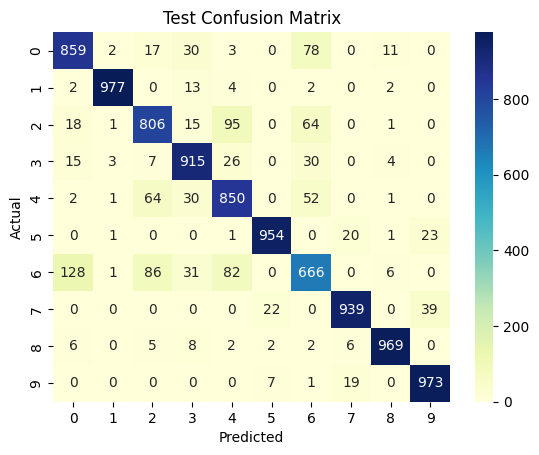

In [70]:
# Initialize a new model and set its weights
loaded_model = NeuralNetwork(input_size=784, hidden_layer_size=256, output_size=10, learning_rate=0.001)
loaded_model.set_weights(loaded_weights)

loaded_model.forward(X_test)  
y_pred = np.argmax(loaded_model.softmax.output, axis=1)  

accuracy = np.mean(y_pred == y_test) * 100  
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Macro F1 Score: {f1}")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()